# Setup

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xml.etree.ElementTree as ET
import re

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#!pip3 install -U scikit-learn

In [ ]:
##!python

In [ ]:
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

#Libraries for NLP
import nltk

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# from google.colab import files
# uploaded = files.upload()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Combine social histories of each patient into a unified record

In [ ]:
def read_xml_file(filepath):
    with open(filepath, "r", encoding="utf-8") as file:
        xml_string = file.read()
    return xml_string.strip()

In [ ]:
def extract_social_history(text):
  # Split the sections
  history = split_sections(text)

  # delete last one in history, as 90% of the time it is the title of the next section
  if history:
    history = history[:history.rfind('\n')]
    #print("FOUND: " + history)

  return history

In [ ]:
# def split_sections(text):
#   keywordsList = ["\nsocial history", "\nsh", "\nsocial and family history",
#                   " social history", " sh", " social and family history"]
#   colonSplit = text.split(':') # Split everything into a list cut by cols
#   for i in range(0, len(colonSplit)-1):
#     ele = colonSplit[i]

#     if len(ele) >= 26:
#       ele = ele[-26:]

#     ele = ele.strip().lower()
#     # see if ele is a social history.
#     for key in keywordsList:
#       # if len(ele) >= len(key) and ele[-len(key):] == key:
#         # if key == 'sh' and ele[-3]
#         # return next ele because the way the data is set up e.g. "sh: ...."
#         if key in ele:
#           return colonSplit[i+1]

#   return None

In [ ]:
def split_sections(text):
  keywordsList = ["\nsocial history", "\nsh", "\nsocial and family history",
                  " social history", " sh", " social and family history"]
  colonSplit = text.split(':') # Split everything into a list cut by cols
  for i in range(0, len(colonSplit)-1):
    ele = colonSplit[i]

    # if len(ele) >= 25:
    #   ele = ele[-25:]

    ele = ele.strip().lower()
    # see if ele is a social history.
    for key in keywordsList:
      if len(ele) > len(key) and ele[-len(key):].lower() == key:
          return colonSplit[i+1]



        # return next ele because the way the data is set up e.g. "sh: ...."
        # if key in ele:
        #   return colonSplit[i+1]

  return None

In [ ]:
def process_folder(folder_path):
    data = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".xml"):
            #print(folder_path + filename)
            xml_string = read_xml_file(folder_path + filename)
            text = ET.fromstring(xml_string).find('.//TEXT').text.strip()
            social_history = extract_social_history(text)
            data.append({'Text': text, 'Social History': social_history})

    df = pd.DataFrame(data)
    return df



In [ ]:
folder_path = '/content/drive/MyDrive/Project3_data/'
df = process_folder(folder_path)

#df.head(15)

In [ ]:
## Finding Numbers for the amount of social histories retrieved


#print(df["Social_History"].isna().sum())
#print(df.shape[0])
print(df.count())

diff = df.shape[0] - df["Social History"].isna().sum()

numSH = 0 # number of "social history" isntances in the data?
for entry in df["Text"]:
  if "social history" in entry.lower():
    numSH += 1

print("Total instances of 'social history' = " + str(numSH))

print("missed SH = "+str(numSH - diff))

Text              1304
Social History     353
dtype: int64
Total instances of 'social history' = 513
missed SH = 160


# Exploratory Analysis

In [ ]:
text = df["Social History"].fillna(" ")

In [ ]:
#Function to get top words and counts
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [ ]:
#Removing stop words and developing a list of top words in abstracts
def topWordList(text, title):
  cv = CountVectorizer(stop_words='english')
  words, word_val = get_top_n_words(n_top_words=15, count_vectorizer=cv, text_data=text)
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.bar(words, word_val)
  ax.set_xticklabels(words, rotation='vertical');
  ax.set_title(title);
  ax.set_xlabel('Word');
  ax.set_ylabel('Number of occurences');
  plt.show()
  print(range(len(words)))

<ipython-input-24-c76bacd4d34a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation='vertical');


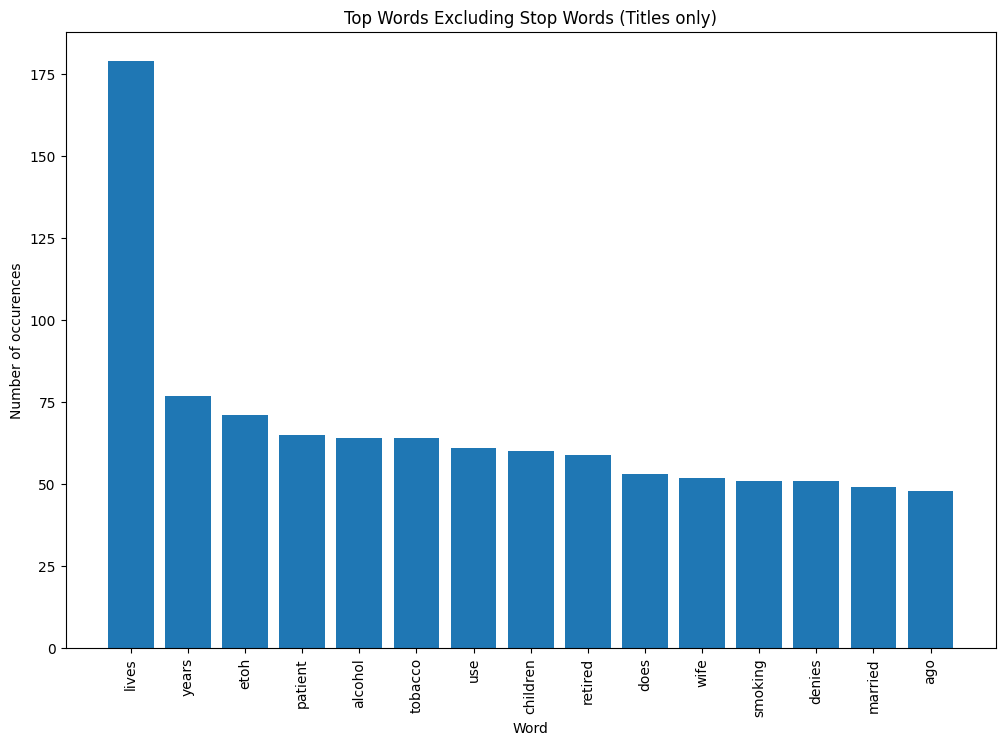

range(0, 15)


In [ ]:
######### TITLES
topWordList(text, "Top Words Excluding Stop Words (Titles only)")

# Topic Modeling

## Preprocessing for LDA

In [ ]:
#Making a class for both tokenization and lemmatization
lemm = nltk.WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Storing all training text in a list
text = list(text)

# Calling the overwritten count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2, stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

## LDA (Sklearn)

In [ ]:
#number of topics
n_topics=5

In [ ]:
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online',
                                learning_offset=50., random_state=0, verbose =0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
lda_topic_matrix = lda.fit_transform(tf)

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
# Getting the categories and counts from the lda model
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
# Function to get top words from each category
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))
    return top_words

In [ ]:
# Printing words from each topic
top_n_words = get_top_n_words(20, lda_keys, tf, tf_vectorizer)

for i in range(len(top_n_words)):
    print("Topic {}:\n ".format(i), top_n_words[i] + "\n")

Topic 0:
  safe describes 39 nuku ca pet life alofa author friedman husband year daugthers grandchild child fulltime originally married marriage mt

Topic 1:
  life year etoh wife ago smoking child work quit retired alcohol tobacco history patient married drug denies son pack currently

Topic 2:
  exposure travel smoke married work doe ro retired child tb industrial visited patient recently pain away manufacturing fatigue asbestos fatigued

Topic 3:
  po patient present continues qd non mg tablet reveals normal daughter exam 20 chest day abdomen neck rash senior regular

Topic 4:
  life use drug doe tobacco alcohol smoke drink denies etoh family retired patient daughter child past smoker history married year



In [ ]:
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)
# Takes a while just fyi

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1304 samples in 0.002s...
[t-SNE] Computed neighbors for 1304 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1304
[t-SNE] Computed conditional probabilities for sample 1304 / 1304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.673641
[t-SNE] KL divergence after 2000 iterations: 0.137014


In [ ]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])

        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
# Colourmap for the visualization
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [ ]:
#Top 3 word from each topic to use in plot
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)

#Getting the mean of the topic vector for the visualization
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

##Creating the t-SNE plot
plot = figure(title="t-SNE Clustering of {} LDA Topics for Titles and Abstracts Dataset".format(n_topics), width=600, height=600)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1],
                  text=top_3_words_lda[t], text_color='black')
    plot.add_layout(label)

show(plot)

In [ ]:
doc_topic = lda.transform(tf)

for n in range(20):
    topic_most_pr = doc_topic[n].argmax()
    print("Document #{} - topic: {}\n".format(n,topic_most_pr))

Document #0 - topic: 1

Document #1 - topic: 3

Document #2 - topic: 0

Document #3 - topic: 1

Document #4 - topic: 0

Document #5 - topic: 0

Document #6 - topic: 0

Document #7 - topic: 0

Document #8 - topic: 0

Document #9 - topic: 0

Document #10 - topic: 0

Document #11 - topic: 0

Document #12 - topic: 0

Document #13 - topic: 0

Document #14 - topic: 0

Document #15 - topic: 0

Document #16 - topic: 0

Document #17 - topic: 0

Document #18 - topic: 0

Document #19 - topic: 1



## Advanced Analysis of LDA

My main goal is to
1. Find the most relevant articles for each topic so they can be used as the links for further research
2. maybe find another way to list the most relevant articles such as using rating or views (later)

In [ ]:
# making a dataframe from the document-topic matrix
doc_topic_df = pd.DataFrame(data=doc_topic)
doc_topic_df

,0,1,2,3,4
0,0.033391,0.865623,0.033445,0.033517,0.034024
1,0.015403,0.016469,0.015397,0.608873,0.343858
2,0.200000,0.200000,0.200000,0.200000,0.200000
3,0.016801,0.640598,0.016682,0.308841,0.017078
4,0.200000,0.200000,0.200000,0.200000,0.200000
...,...,...,...,...,...
1299,0.200000,0.200000,0.200000,0.200000,0.200000
1300,0.022261,0.910844,0.022281,0.022231,0.022382
1301,0.200000,0.200000,0.200000,0.200000,0.200000
1302,0.200000,0.200000,0.200000,0.200000,0.200000


In [ ]:
# printing the top 'n' articles for each topic
for (columnName, columnData) in doc_topic_df.items():
    n = 3
    print('Topic #', columnName)
    sorted_topic = pd.DataFrame(data=columnData.values).sort_values(by=0, ascending=False)
    sorted_topic.columns = [columnName]
    print(sorted_topic[:n])

    # store IDs and titles of top articles in a dataframe
    ids = sorted_topic[:n].index

Topic # 0
             0
1277  0.966426
21    0.966426
183   0.964922
Topic # 1
            1
106  0.978744
157  0.970947
275  0.968850
Topic # 2
             2
819   0.983220
990   0.982109
1113  0.952601
Topic # 3
             3
56    0.992960
293   0.987732
1026  0.984984
Topic # 4
            4
65   0.977445
778  0.970200
696  0.970200


0    990
1    180
4    106
3     19
2      9
Name: count, dtype: int64

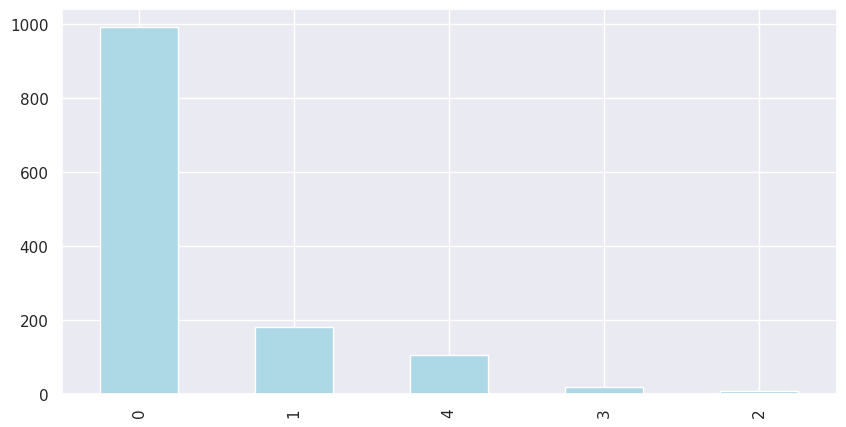

In [ ]:
#plotting the distribution of documents over each topic
sns.set(rc={'figure.figsize':(10,5)})
doc_topic_df.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#store the distributions in a dataframe
distribution = doc_topic_df.idxmax(axis=1).value_counts()
distribution